# Fleshed out example
NOTE: This notebook is pretty rough. It will development  change during development of the code..

#### Imports

In [141]:
# Useful for plottimg
from matplotlib import pyplot as plt

# Useful for calculations
import numpy as np

# Useful for getting lists of files, etc
import os
import glob

# I use *pickle* to load some external "pickled" datasets. Not necessary for anything else. 
import pickle
# Also use xarray to load some external data
import xarray as xr

# I use *mpl.dates* to enter some dates. Not necessary for anything else. 
from matplotlib import dates
from matplotlib.dates import date2num, num2date

### Find modules and  files we will work with

In [66]:
# Load the modules

# Changing directories because we need to be in the directory below the functions
# (may make this a bit neater later..)
os.chdir('/home/oyvindl/work/code/git_public/sigpyproc/examples/')
os.chdir('../')
from sigpyproc import sig_load, sig_append, sig_calc, sig_draft
from sigpyproc import sig_open_water_correction, sig_ice_vel, sig_toolbox, sig_append
os.chdir('examples/')

In [67]:
# Make a list of the .mat files we want to load 
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

## Load the data 

##### Load from matfiles to a neatly xarray Dataset 

- Wraps from a simgle time dimension to *(TIME, SAMPLE)*
- Concatenates the many .mat files to a single file
- Various formatting stuff
- Calculate tilt
- Estimates sea ice presence from FOM (and adds "sea ice concentration" fields)

Specifying lat/lon here - that can also be done later

This step takes a while (a minute or so?).

Throws some errors that I haven't investigated (don't seem to matter but I don't want to suppress them, until I'm sure what they are)

In [68]:
DX = sig_load.matfiles_to_dataset(flist, lat = 79.589, lon = 28.097)

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


1870992 time points, 38979 ensembles. Sample per ensemble: 48
Done. Run sig_funcs.overview() to print some additional details.


##### Have a quick look at the data 

We can look at the file interactively by just typing "DX".

We can also run *sig_load.overview(DX)* for soem very basic statistics.

We can also run *sig_toolbox.histogram(DX, [variable name]) to look at the distribution of a variable 

In [69]:
sig_load.overview(DX)


TIME RANGE:
06 Oct 2018 12:00  -->  16 Nov 2019 12:30  (406.0 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure: 20.6 dbar (0.5 dbar)  - with fixed atm offset 9.500 dbar.

SIZE:
Total 1870992 time points.
Split into 38979 ensembles with 48 sample per ensemble.
Ocean velocity bins: 16.


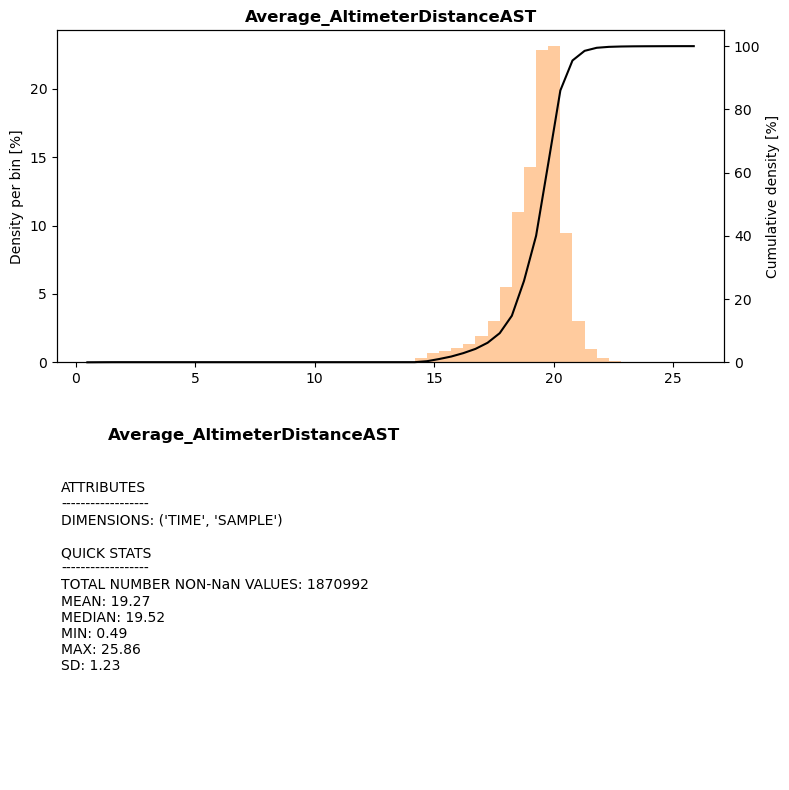

In [70]:
sig_toolbox.histogram(DX, 'Average_AltimeterDistanceAST')

## Append some external datasets

We can append external data to *DX* using the *sig_append* module. The functions in the module interpolates external data onto the *TIME* grid.

The function *sig_append.add_to_sigdata* is general and can be used to append whatever can be of use.

There are specified functions for appending specific things that are used in subsequent processing: 

- *sig_append.append_atm_pres*: Append **sea level pressure** (used for depth correction)
- *sig_append.append_ctd*: Append **S, T, P from CTD sensor** (used for density and sound speed corrections)
- *sig_append.set_lat, set_lon*: Add (single-value) **lat/lon** (if it wasn't done in the initial loading step)
- *sig_append.append_magdec*: Add **magnetic declination** (used for correction of velocity directions). 

#### Append atmospheric pressure from CARRA atmospheric reanalysis 

Load a dataset containing sea level pressure.

(I have previously collected these data from CARRA reanalysis).

Note that these should be provided in units of **decibars**.

In [71]:
with open('../testing/development/CARRA_MSL_M1_temp.p', 'rb') as f:
    dmsl = pickle.load(f)

In [72]:
carra_m1 = xr.open_dataset('/media/oyvindl/ratatosk/data/carra/selected_points/carra_18_22_M1.nc')

In [73]:
DX_no_msl = DX.copy()

In [74]:
# Append to the dataset
DX = sig_append.append_atm_pres(DX, carra_m1.msl.data*1e-4, date2num(carra_m1.time))

We now have a *p_atmo* field in *DX*:
Make a quick plot to check that our interpolation worked:

(17832.0, 17842.0)

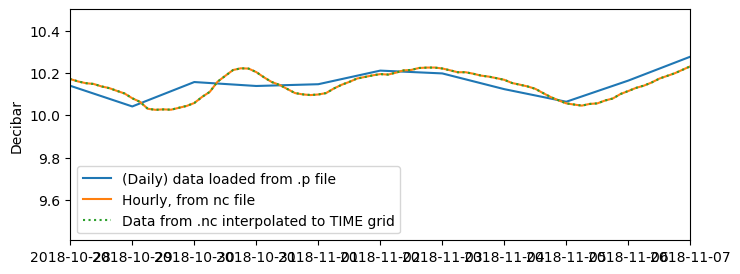

In [75]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.plot_date(dmsl.time, dmsl.MSL, '-', label = '(Daily) data loaded from .p file')
ax.plot(carra_m1.time, carra_m1.msl*1e-4, '-', label = 'Hourly, from nc file')
ax.plot(DX.TIME, DX.p_atmo, ':', label = 'Data from .nc interpolated to TIME grid')

ax.legend()
ax.set_ylabel('Decibar')
ax.set_xlim(dmsl.time[300], dmsl.time[310])

#### Append CTD data
Next, we add data from a CTD sensor that was mounted rigth below the Signature. We will use it to improve our sound speed and density estimates - it is also interesting to includefor analysis purposes!

In [76]:
# Load data (which I have prepared in advance)

with open('../testing/development/CARRA_CTD_M1_1_temp.p', 'rb') as f:
    dctd = pickle.load(f)
    
# Chop away nan ends..
ctd_sl = slice(3, -3)
for key in dctd.keys():
    dctd[key] = dctd[key][ctd_sl]

In [77]:
# Append to the dataset
# (Specifying serial number and description is optional!)
DX = sig_append.append_ctd(DX, dctd.TEMP, dctd.SP, dctd.pres, dctd.time,
             instr_SN = '11111', 
           instr_desc = 'RBR Concerto CTD sensor mounted right below the Signature' )

The *append_ctd* function read T/S/p variables. These were converted to TEOS-10 using the *gsw* module. It also calculated sound speed and density.

We therefore have some new fields in DX, all with the suffix *_CTD*: *SA_CTD, CT_CTD, sound_speed_CTD..*. The descriptions we prescribed, as well as other metadata such as units and full name, should be available in the variable attributes, e.g.:

In [78]:
DX.SA_CTD

<xarray.DataArray 'SA_CTD' (TIME: 38979)>
array([34.39900199, 34.39882242, 34.39904116, ..., 33.19516176,
       33.1471796 , 33.09919743])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    long_name:               Absolute Salinity
    units:                   g kg-1
    Instrument description:  RBR Concerto CTD sensor mounted right below the ...
    Instrument SN:           11111
    note:                    Calculated using the gsw module. Linearly interp...

#### Append magnetic declination

In this case, we know that the declination only changes by <0.5 degrees over the deployment. For now, we are happy using a linear interpolation based two values we found for two points in time (from the EMM, extracted using this online calculator: https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm)

In [79]:
mag_time = [dates.date2num(dates.datetime.date(2018, 9, 1)), 
            dates.date2num(dates.datetime.date(2019, 9, 1))]
magdec = [19.7683447942, 20.1825371364]

In [80]:
# Append to DX (the attributes are not necessary - 
# but it's a good idea to keep track of this sort 
# of stuff in the file metadata!)

DX = sig_append.append_magdec(DX, magdec, mag_time, 
         attrs = {'note':('Magdec interpolated between extracted from EMM, '
              'extracted using this online calculator: '
              'https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm')})

In [81]:
# Inspect magdec in DX
DX.magdec

<xarray.DataArray 'magdec' (TIME: 38979)>
array([19.80862957, 19.80864139, 19.80865321, ..., 20.26934763,
       20.26935945, 20.26937127])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    long_name:  Magnetic declination
    units:      degrees
    note:       Magdec interpolated between extracted from EMM, extracted usi...

Note that the append_magdec *extrapolates*. Let's look at the actual values: 

Text(0, 0.5, 'Degrees')

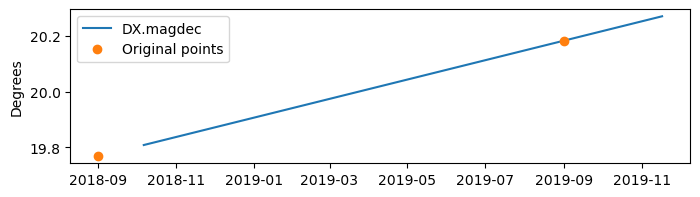

In [82]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.magdec, label = 'DX.magdec')
ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.legend()
ax.set_ylabel('Degrees')

#### Add AMSR2 SIC

Adding SIC is not necessary for anything. But it is an example of a information that can be useful to include for analysis - remote sensing SIC is also useful for comparing the SIC we have computed from in-situ data! 

In [83]:
# Load previously extracted data
sic = xr.open_dataset('/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc')
sic_data = sic.SIC_m1
sic_time = sic.time+0.5 # We add half a day because the daily time stamp is at 00:00

In [84]:
# 'SIC_AMSR2' specified what we want this variable to be called. A name is mandatory,
# "attrs" specifies attributes/metedata info. Not necessary but useful!
DX = sig_append.add_to_sigdata(DX, sic_data, sic_time, 'SIC_AMSR2', 
               attrs = {'long_name':'AMSR2 UoB sea ice concentration',
        'description':'SIC extracted from the nearest grid point.',
        'sourcefile':'/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc'})

In [85]:
# inspect:
DX.SIC_AMSR2

<xarray.DataArray 'SIC_AMSR2' (TIME: 38979)>
array([ 0.        ,  0.        ,  0.        , ..., 93.25573346,
       93.26134011, 93.26694676])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    long_name:    AMSR2 UoB sea ice concentration
    description:  SIC extracted from the nearest grid point.
    sourcefile:   /home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2...

##### Quick look and comparison with "in situ SIC" 
In the *sig_load.matfiles_to_dataset* call in the beginning, we calculated ice presence uring the *FOM* metric, and estimated "SIC" based on this. 

Below we do a quick comparison with the remote sensing SIC that we just added.

Note: We use the function *sig_calc.daily_median* to calculate daily medians

In [161]:
for nn in list(DX.keys()):
    print(nn)

time_average
time_average_ice
Average_Time
Average_Status
Average_ExtStatus
Average_Error
Average_EnsembleCount
Average_NBeams
Average_NCells
Average_BeamToChannelMapping
Average_AmbiguityVel
Average_VelEast
Average_VelNorth
Average_VelUp1
Average_VelUp2
Average_AmpBeam1
Average_AmpBeam2
Average_AmpBeam3
Average_AmpBeam4
Average_CorBeam1
Average_CorBeam2
Average_CorBeam3
Average_CorBeam4
Average_AltimeterDistanceLE
Average_AltimeterQualityLE
Average_AltimeterStatus
Average_AltimeterDistanceAST
Average_AltimeterQualityAST
Average_AltimeterTimeOffsetAST
Average_AltimeterPressure
Average_Battery
Average_Heading
Average_Pitch
Average_Roll
Average_Temperature
Average_Soundspeed
Average_Pressure
Average_PressureSensorTemperature
Average_RTCTemperature
Average_MagnetometerTemperature
Average_TransmitEnergy
Average_Magnetometer
Average_Accelerometer
Average_NominalCorrelation
AverageIce_Time
AverageIce_Status
AverageIce_Error
AverageIce_Battery
AverageIce_Heading
AverageIce_Pitch
AverageIce_Ro

Text(0, 0.5, 'Concentration [%]')

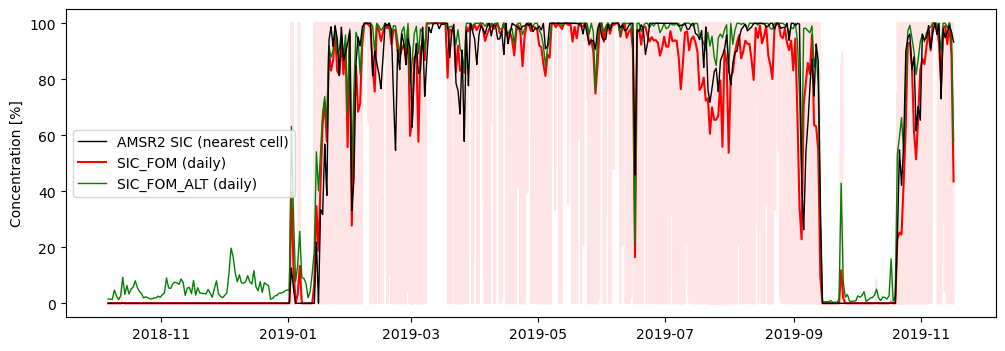

In [86]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(DX.TIME, DX.SIC_AMSR2, 'k', zorder = 20, lw = 1, label ='AMSR2 SIC (nearest cell)')
ax.plot(DX.TIME, DX.SIC_FOM, color = 'r', alpha = 0.1)
SIC_FOM_dat, td = sig_calc.daily_average(DX.SIC_FOM, DX.TIME, function = 'mean')
ax.plot(td+0.5, SIC_FOM_dat, color = 'r', alpha = 1, label = 'SIC_FOM (daily)')
SIC_FOM_ALT_dat, td = sig_calc.daily_average(DX.SIC_FOM_ALT, DX.TIME, function = 'mean')
ax.plot_date(td+0.5, SIC_FOM_ALT_dat, '-', color = 'g', alpha = 1, 
             lw = 1, label = 'SIC_FOM_ALT (daily)')
ax.legend()

ax.set_ylabel('Concentration [%]');

-> Looks pretty good!

### Calculate depth
Before we calculate ice drafts and velocities, we want to compute the instrument depth $h$. This is done from a hydrostatic approximation  $$h = \frac{p}{\rho g}$$

Where $p$ is the ocean pressure (*Average_AltimeterPressure*) where we have added back the in-build atmospheric correction, but *subtracted* our the time-varying atmopheric pressure that we added earlier (*p_atmo*).  

$\rho$ is density from CTD (*rho_CTD*) and $g$ is (latitude-dependent) gravitational acceleration calculated using the function *gsw.grav*.

It is possible to calculate depth without atmospheric pressure, in-situ density etc. The function uses everything that is available unless we specify *corr_atmo=False* or *corr_CTD_density=False* in the function call. 

In [87]:
# Doing one calculation withotu the TD densioty correction to see if there is a difference..

DX = sig_calc.dep_from_p(DX, corr_CTD_density=True)

DX0 = DX.copy()
DX0 =sig_calc.dep_from_p(DX0, corr_CTD_density=False)

Continuing using fixed rho. Choose: 
(R): Use rho = 1027 kg m-3, or
(S): Specify fixed rho
r
Continuing with fixed rho = 1027.0 kg m-3


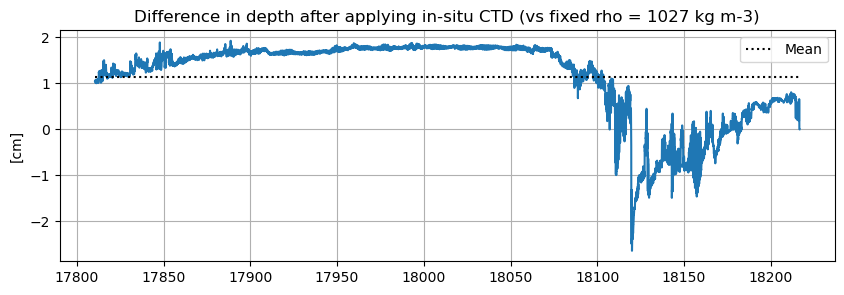

In [88]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(DX.TIME, (DX0.depth- DX.depth).mean(dim='SAMPLE')*1e2, )
ax.set_ylabel('[cm]')
ax.set_title('Difference in depth after applying in-situ CTD (vs fixed rho = 1027 kg m-3)')
meandiff = float((DX0.depth-DX.depth).mean())*1e2
ax.plot([float(DX.TIME[0]), float(DX.TIME[-1])], np.ones(2)*meandiff, ':k', label = 'Mean')
ax.legend(); ax.grid()

As we see, the *note* field details which corrections have been applied. 

**A quick sanity check:** we should have $depth\sim~0$ after the instrument was brought on board

Text(0.5, 1.0, 'Instrument "depth" at the end of deployment')

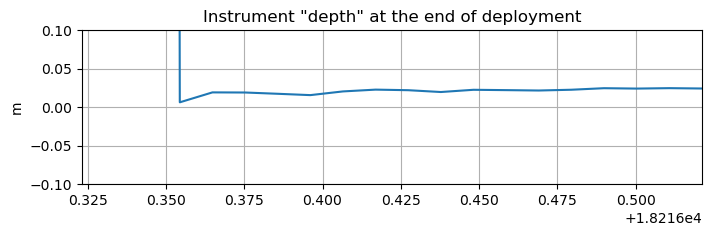

In [89]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.depth.mean(dim = 'SAMPLE'))#, label = 'DX.magdec')

#ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.set_ylabel('m')
ax.set_xlim(DX.TIME[-20], DX.TIME[-1])
ax.set_ylim(-0.1, 0.1)
ax.grid()
ax.set_title('Instrument "depth" at the end of deployment')

-> Yep, we are about 3 cm off which **seems pretty good.**

### Chopping away on-ship measurements
We actually don't want to include the measurements taken on deck or after/during deployments. We can easily chop everything using the function *sig_load.chop*:

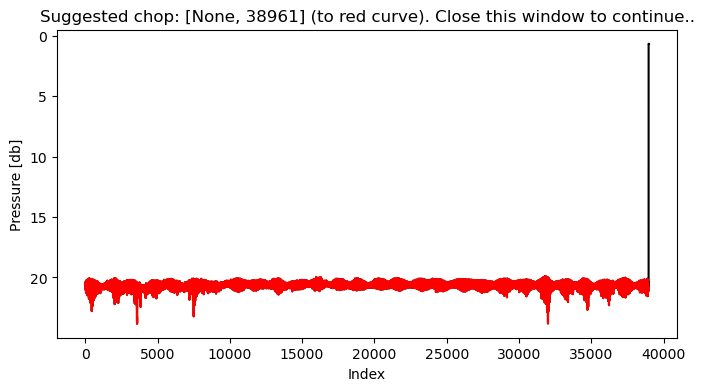

Suggested chop: [None, 38961] (to red curve)
Accept (y/n)?: y
Chopping to index [None, 38961]
Chopped 18 ensembles using -> [None, 38961] (total ensembles 38979 -> 38961)


In [90]:
# Good starting point: Just call the function and follow the prompts. 
DX = sig_load.chop(DX)

We have now chopped away the time on deck durign the recovery, reducing the size of the dataset a bit.

Note that this information is preserved in *DX.history* attribute 

In [ ]:
print(DX.history)

# Draft

We are now ready to calculate the sea ice draft. The basic approach is:

1. Calculate depth of the scattering surface from depth/tilt/sound/speed/altimeter distance.
    - All valid values (open water and ice) are stored as *SURFACE_DEPTH_*
    - Only values during estimated sea ice presence are stored as *SEA_ICE_DRAFT_*
2. Extract a time-varying "open water correction" forcing the long-time moving average open water values to be near zero.
    - Calculate a sound speed correction factor $\beta$ which would make the necessary correction to the open water values.
3. Repeat step 1, but now applying the sound speed $\beta$ to the distance calculation.

##### Step 1: Initial calculation of surface depths


In [91]:
DX = sig_draft.calculate_draft(DX)

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


We have now added a bunch of new fields to *DX* (e.g. *SURFACE_DEPTH_LE*, *SEA_ICE_DRAFT_AST*..).

Note that We do the calculation - separately - for both the *AST* and *LE* altimeter estimates. 

For the *LE* estimate (which typically is better/less noisy, but detects "false keels" near the transducer), we **drop all LE samples where AST and LE disagree by > 0.5 m**. In this case that means dropping a *lot* of samples (something like 1/3 of the dataset), but the hope is that it gives a better estimate.

In [92]:
DX.SURFACE_DEPTH_AST

<xarray.DataArray 'SURFACE_DEPTH_AST' (TIME: 38961, SAMPLE: 48)>
array([[ 0.13235946,  0.44822033, -0.46264256, ..., -0.12436397,
         0.19573864, -0.04956068],
       [ 0.12523277,  0.17080642, -0.12409695, ..., -0.24109239,
         0.09172341,  0.55600949],
       [-0.92407287, -0.18567779,  0.41459001, ..., -0.24513305,
         0.35100239,  0.17184693],
       ...,
       [ 0.05475895,  0.02967111,  0.05721907, ...,  0.64499224,
         0.67059321,  0.67098482],
       [ 0.40130918,  0.37469533,  0.39698189, ...,  0.41041258,
         0.43758322,  0.46144991],
       [ 2.65961142,  1.66815244,  2.97974418, ...,  2.54761571,
         0.03724053,  4.297252  ]])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
  * SAMPLE   (SAMPLE) int64 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
Attributes:
    long_name:  Depth of the scattering surface observed by the Altimeter (AST)
    units:      m
    note:       From AST altimeter distances.\n\nComputed with the function s...

##### Step 2: Open water correction
*(Note: this can take a minute or so to run)*

(Describe this here in more detailed later..) 

In [93]:
# Step 2: Open water correc
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

### Find sound speed correction Beta

In [94]:
# Running with the default parameters for now..
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

*Note*: We have **not** made any adjustments to the draft yet - just estimated $\beta$ (added as the *BETA_open_water_corr_* fields). 

We can examine the correction now to see if we are happy with it using teh *compare_OW_correction* funcion:
(This function is bulky and should be made more practical)

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


LE: Mean (median) offset: 17.2 cm (17.6 cm)
AST: Mean (median) offset: 3.8 cm (3.9 cm)
LE: Mean (median) dBETA: 8.7 (9.0)
AST: Mean (median) dBETA: 1.9 (2.0)
LE - MEAN SEA ICE DRAFT:
Before OW correction: 1.41 m
After OW correction: 1.27 m
AST - MEAN SEA ICE DRAFT:
Before OW correction: 1.15 m
After OW correction: 1.11 m


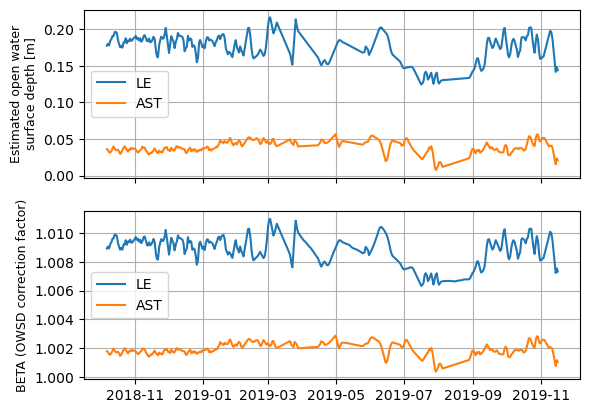

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


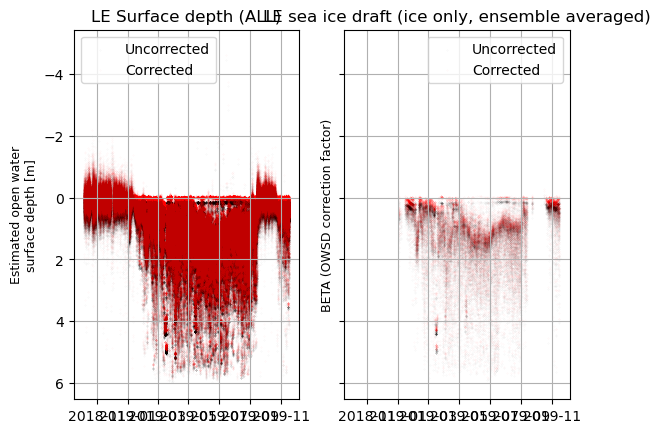

In [95]:
sig_open_water_correction.compare_OW_correction(DX)

So we can see that we make a larger adjustment  for LE than (eq to ~18 cm) for AST (eq to ~4 cm).

Will look into this a bit later - but for now we will assume that we are happy with out $beta$, and recompute the draft:

### Recompute draft

In [96]:
DX = sig_draft.calculate_draft(DX)

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


We have now updated the calculation to include oue $\beta$,m which should improve the estimate and bring open water values nearer to zero.

if we look at the *SEA_ICE_DRAFT_* and *SURFACE_DEPTH_* fields we should see that this is now specified in the metadata (the *note* field).

##### Quick histogram
We can use the *sig_toolbox.histogram* function for a quick look at the results (also shows the attributes including the *note* field)

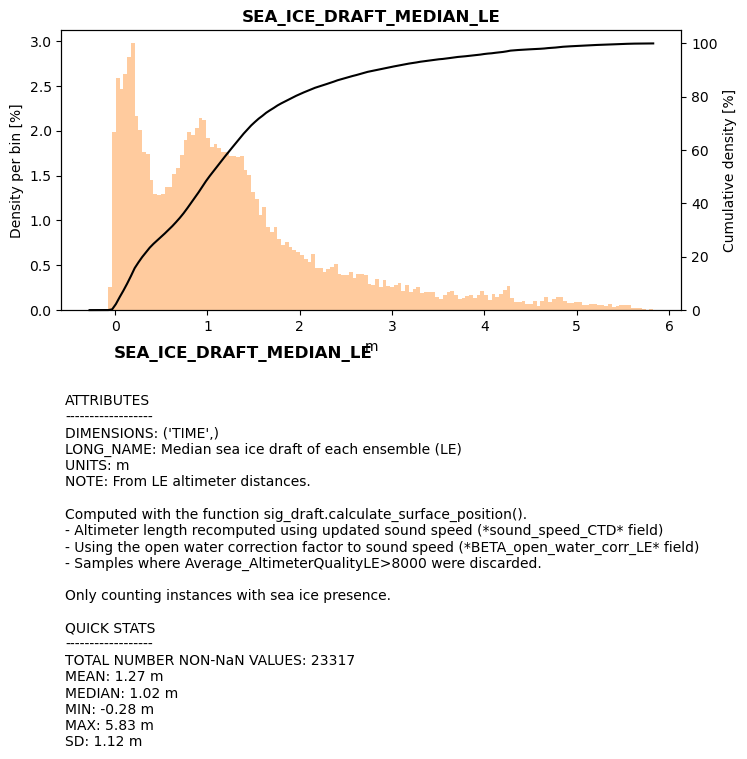

In [98]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_MEDIAN_LE', nbins = 150)

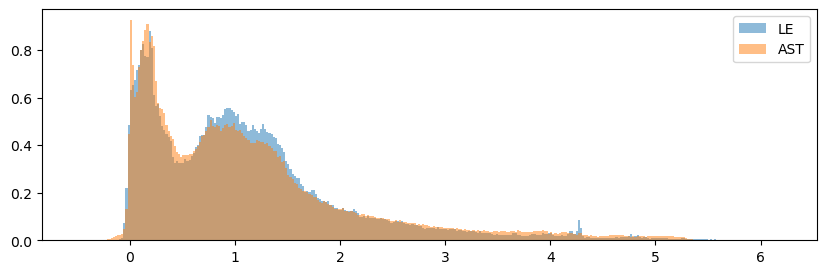

In [126]:
fig, ax = plt.subplots( figsize = (10, 3))
hkws = {'density':True, 'bins':335, 'range':(-0.5, 6.2), 'alpha':0.5}
ax.hist((DX.SEA_ICE_DRAFT_LE).values.flatten(), **hkws, label = 'LE');
ax.hist((DX.SEA_ICE_DRAFT_AST).values.flatten(), **hkws, label = 'AST');
ax.legend()

In [123]:
# Compare SD
mean_sd_LE = float(DX.SEA_ICE_DRAFT_LE.std(dim = 'SAMPLE').mean())
mean_sd_AST = float(DX.SEA_ICE_DRAFT_AST.std(dim = 'SAMPLE').mean())
print('Mean SD across samples:')
print('AST: %.2f cm'%(1e2*mean_sd_AST))
print('LE: %.2f cm'%(1e2*mean_sd_LE))

Mean SD across samples:
AST: 23.05 cm
LE: 15.66 cm


/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


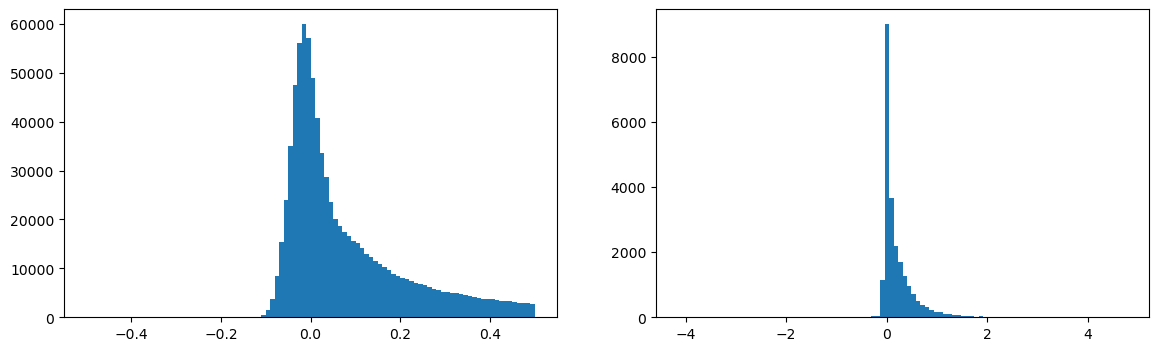

In [110]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].hist((DX.SEA_ICE_DRAFT_LE-DX.SEA_ICE_DRAFT_AST).values.flatten(), 100);
ax[1].hist((DX.SEA_ICE_DRAFT_MEDIAN_LE-DX.SEA_ICE_DRAFT_MEDIAN_AST).values, 100);

**TO DO**

- Continue through with ice velocity. (**X**?)
    - Processing + diagnosis
- Ocean velocity can be prioritised down for now..
- Include chopping functions (**X**?)
- Include save to nc functions
- Make static page for git

## Ice velocity

The ice drift velocity calculation is simpler, consisting of:

- Loading the velocities: *uice, vice* from *AverageIce_VelEast/_VelNorth*
- Applying a quality criterion requiring FOM<10 000 for all 4 beams (equivalent to requiring *ICE_IN_SAMPLE==True*)
    - Rejecting all samples where this does not hold 
- Calculate ensemble median values *Uice, Vice* (default is to use medians, can also use means).
   - Also creating *Uice_SC, Vice_SD* - containing the ensemble standard deviation. 
- Rotate the current vectors to account for magnetic declination.
  - Applied to both *uice* and *Uice*. (Also applying to ocean velocities now..)

##### Create the ice uv fields 

In [127]:
DX = sig_ice_vel.calculate_drift(DX)

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


.. we have now added *uice, vice, Uice, Vice, Uice_SD, Vice_SD* to *DX*.

We can compare *uice* with the original *AverageIce_VelEast* field to see what out FOM cleaning has done:

In [131]:
DX.TIME[9000].data

array(17904.25027634)

In [133]:
ax[1].get_xlim()

(17790.208609674726, 18236.625276341434)

Text(0.1, 0.8, 'ZOOMED')

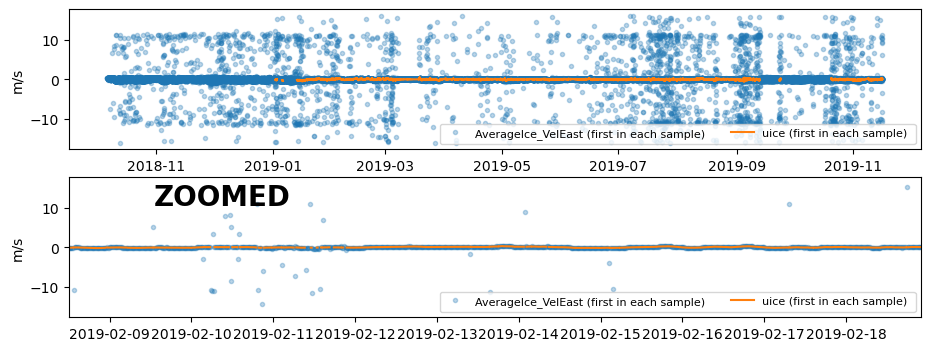

In [147]:
fig, ax = plt.subplots(2, 1, figsize = (11, 4))
for axn in ax:
    axn.plot(DX.TIME, DX.AverageIce_VelEast.isel(SAMPLE=0), '.', alpha = 0.3,label= 'AverageIce_VelEast (first in each sample) ')
    axn.plot_date(DX.TIME, DX.uice.isel(SAMPLE=0), '-', label= 'uice (first in each sample) ')
    axn.set_ylabel('m/s')
    axn.legend(ncol = 2, fontsize = 8, loc = 4)
ax[1].set_xlim(num2date(DX.TIME[12000]), num2date(DX.TIME[13000]))
ax[1].text(0.1, 0.8, 'ZOOMED', fontsize = 20, fontweight = 'bold', transform=ax[1].transAxes)

##### Inspect
The function *sig_toolbox.plot_ellipse_icevel* is useful to get a quick look at the ice velocity data. It shows the u/v spread, mean and low-passed velocity, and the variance ellipse (of the low-passed currents)

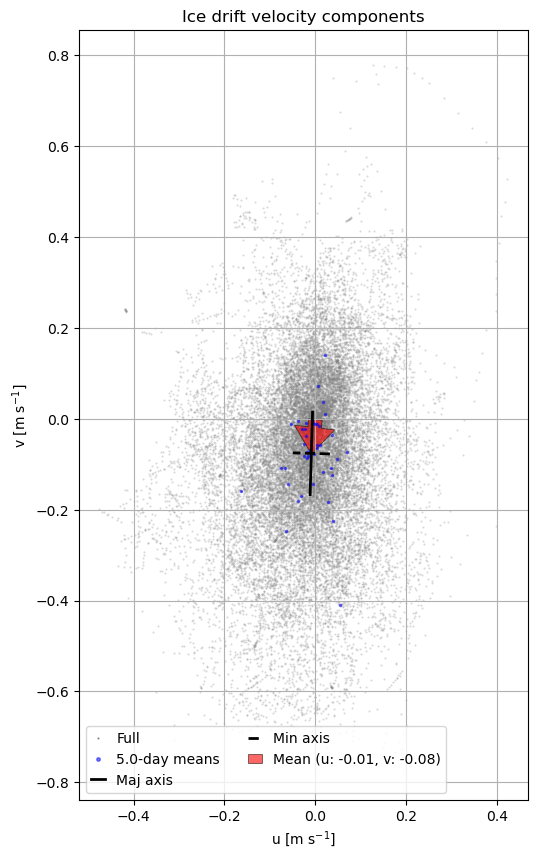

In [148]:
sig_toolbox.plot_ellipse_icevel(DX);

### Rotating for magnetic declination

Earlier, we added the *magdec* field to *DX*. We can now use it to rotate the ice velocity vectors:

In [149]:
DX = sig_ice_vel.rotate_vels_magdec(DX)

The declination is about 20 degrees, so we should expect a CW rotation of the **u** vectors by about 20 degrees. Check this by using *plot_ellipse_icevel* again: 

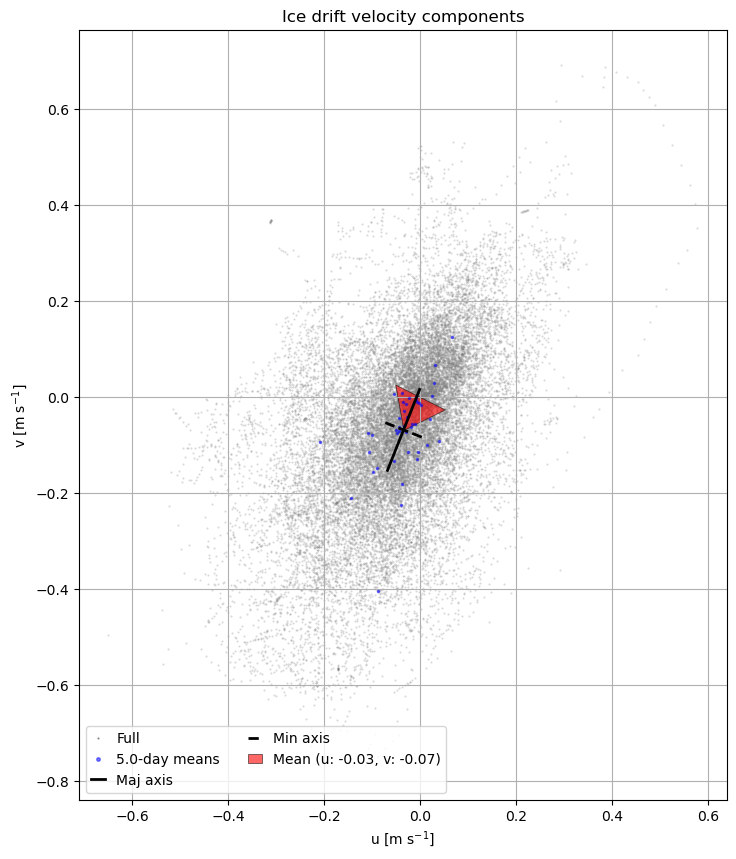

In [150]:
sig_toolbox.plot_ellipse_icevel(DX);

--> OK. 

Note that some metadata has been added to the velocity fields, e.g.:

In [151]:
DX.Uice.attrs

{'units': 'm s-1',
 'long_name': 'Eastward sea ice drift velocity',
 'details': 'Ensemble average (median)',
 'heading_corr': 'Rotated CW by an average of 20.04 degrees to correct for magnetic declination. '}

## Ocean velocities (TBW)

## Exporting

In [159]:
list(DX.keys())

['time_average',
 'time_average_ice',
 'Average_Time',
 'Average_Status',
 'Average_ExtStatus',
 'Average_Error',
 'Average_EnsembleCount',
 'Average_NBeams',
 'Average_NCells',
 'Average_BeamToChannelMapping',
 'Average_AmbiguityVel',
 'Average_VelEast',
 'Average_VelNorth',
 'Average_VelUp1',
 'Average_VelUp2',
 'Average_AmpBeam1',
 'Average_AmpBeam2',
 'Average_AmpBeam3',
 'Average_AmpBeam4',
 'Average_CorBeam1',
 'Average_CorBeam2',
 'Average_CorBeam3',
 'Average_CorBeam4',
 'Average_AltimeterDistanceLE',
 'Average_AltimeterQualityLE',
 'Average_AltimeterStatus',
 'Average_AltimeterDistanceAST',
 'Average_AltimeterQualityAST',
 'Average_AltimeterTimeOffsetAST',
 'Average_AltimeterPressure',
 'Average_Battery',
 'Average_Heading',
 'Average_Pitch',
 'Average_Roll',
 'Average_Temperature',
 'Average_Soundspeed',
 'Average_Pressure',
 'Average_PressureSensorTemperature',
 'Average_RTCTemperature',
 'Average_MagnetometerTemperature',
 'Average_TransmitEnergy',
 'Average_Magnetometer',
